### Alumno: Rubén Alberto Mondragón Zúñiga

In [1]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# Configuración de semilla aleatoria para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# Cargamos el dataset
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
          'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv('pima-indians-diabetes.csv', header=None, names=columns)

In [46]:
# Análisis exploratorio
print("Información del dataset:")
print(data.info())
print("\nEstadísticas descriptivas:")
print(data.describe())

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Estadísticas descriptivas:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531

In [47]:
# Verificamos valores nulos (considerando 0 como valores faltantes en ciertas columnas)
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for column in zero_columns:
    zero_count = len(data[data[column] == 0])
    print(f"\nValores 0 en {column}: {zero_count}")


Valores 0 en Glucose: 5

Valores 0 en BloodPressure: 35

Valores 0 en SkinThickness: 227

Valores 0 en Insulin: 374

Valores 0 en BMI: 11


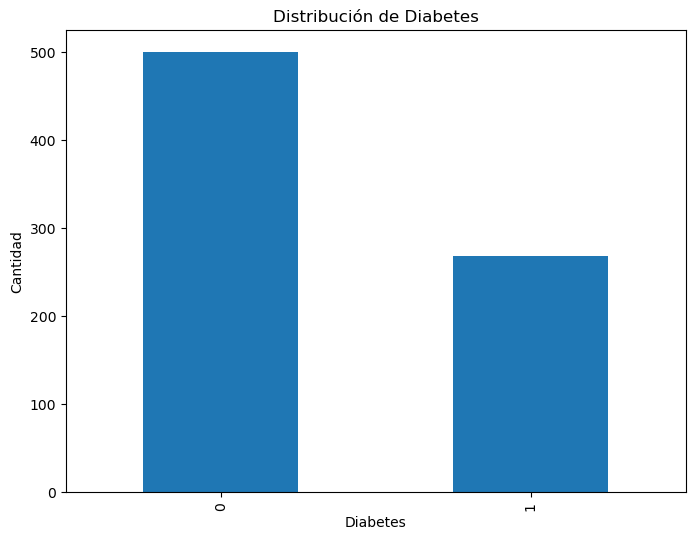

In [48]:
# Visualización de la distribución de la variable objetivo
plt.figure(figsize=(8, 6))
data['Outcome'].value_counts().plot(kind='bar')
plt.title('Distribución de Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Cantidad')
plt.show()

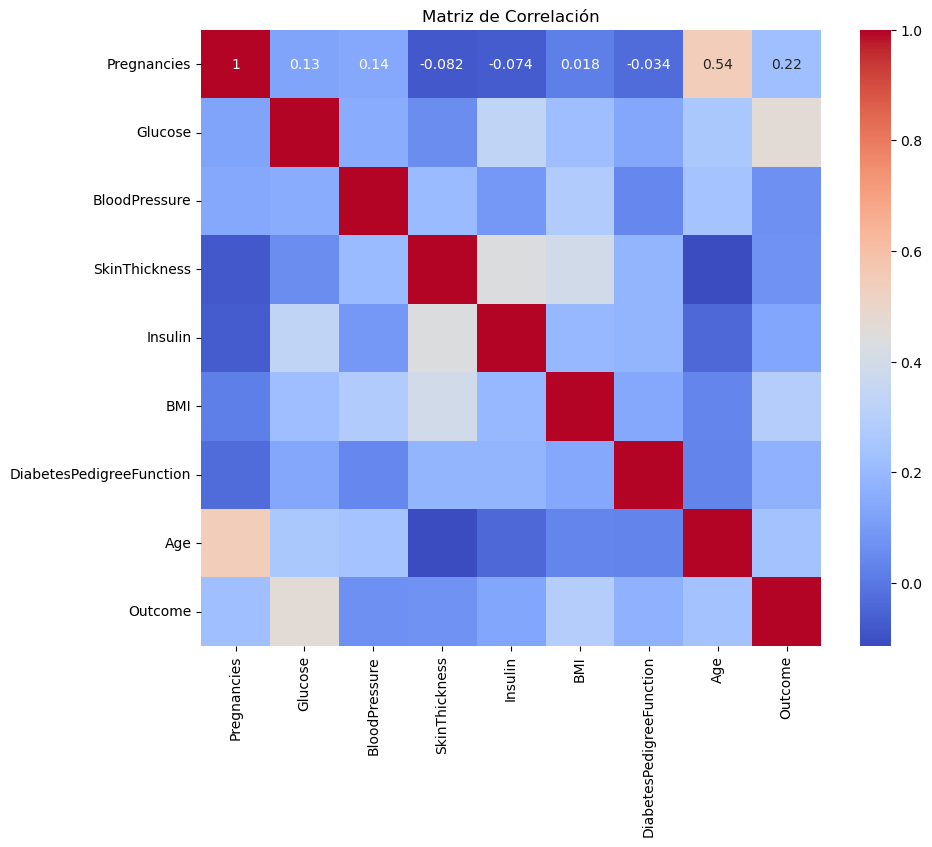

In [49]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

In [65]:
# Mejora en el manejo de valores atípicos y missing values
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    return df

In [66]:
# 2. PREPROCESAMIENTO DE DATOS
#----------------------------
# Tratamiento mejorado de valores faltantes y atípicos
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for column in zero_columns:
    # Reemplazar zeros con NaN
    data[column] = data[column].replace(0, np.nan)
    # Imputar con la mediana
    data[column].fillna(data[column].median(), inplace=True)
    # Manejar outliers
    data = handle_outliers(data, column)


In [67]:
# Separamos features y target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

In [68]:
# Dividimos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
# Escalamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
# 3. DEFINICIÓN DEL DATASET Y DATALOADER
#-------------------------------------

class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y.values)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [71]:
# Creamos los datasets
train_dataset = DiabetesDataset(X_train_scaled, y_train)
test_dataset = DiabetesDataset(X_test_scaled, y_test)

In [72]:
# Creamos los dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [73]:
# 4. DEFINICIÓN DEL MODELO
#------------------------

class DiabetesModel(nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.layer1 = nn.Linear(8, 16)
        self.layer2 = nn.Linear(16, 8)
        self.layer3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.layer3(x))
        return x


In [74]:
# 5. ENTRENAMIENTO DEL MODELO
#---------------------------

# Inicializamos el modelo
model = DiabetesModel()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [75]:
# Función de entrenamiento
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Época [{epoch+1}/500], Loss: {running_loss/len(train_loader):.4f}')

In [76]:
# Entrenamos el modelo
print("Iniciando entrenamiento...")
train_model(model, train_loader, criterion, optimizer, epochs=500)

Iniciando entrenamiento...
Época [10/500], Loss: 0.5323
Época [20/500], Loss: 0.4940
Época [30/500], Loss: 0.4570
Época [40/500], Loss: 0.4775
Época [50/500], Loss: 0.4737
Época [60/500], Loss: 0.4523
Época [70/500], Loss: 0.4466
Época [80/500], Loss: 0.4530
Época [90/500], Loss: 0.4702
Época [100/500], Loss: 0.4565
Época [110/500], Loss: 0.4782
Época [120/500], Loss: 0.4521
Época [130/500], Loss: 0.4394
Época [140/500], Loss: 0.4483
Época [150/500], Loss: 0.4131
Época [160/500], Loss: 0.4430
Época [170/500], Loss: 0.4352
Época [180/500], Loss: 0.4190
Época [190/500], Loss: 0.4251
Época [200/500], Loss: 0.4308
Época [210/500], Loss: 0.4357
Época [220/500], Loss: 0.4378
Época [230/500], Loss: 0.4220
Época [240/500], Loss: 0.4778
Época [250/500], Loss: 0.4277
Época [260/500], Loss: 0.4188
Época [270/500], Loss: 0.4524
Época [280/500], Loss: 0.4510
Época [290/500], Loss: 0.4177
Época [300/500], Loss: 0.4296
Época [310/500], Loss: 0.4102
Época [320/500], Loss: 0.4154
Época [330/500], Loss:

In [77]:
# 6. EVALUACIÓN DEL MODELO
#------------------------

# Función para hacer predicciones
def make_predictions(model, loader):
    model.eval()
    predictions = []
    actual = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() >= 0.5).float()
            predictions.extend(predicted.numpy())
            actual.extend(labels.numpy())
    return np.array(predictions), np.array(actual)

In [84]:
# Hacemos predicciones en los primeros 10 casos de prueba
model.eval()
with torch.no_grad():
    test_inputs = torch.FloatTensor(X_test_scaled[:10])
    test_predictions = model(test_inputs).squeeze().numpy()
    binary_predictions = (test_predictions >= 0.5).astype(int)

In [85]:
# Mostramos los resultados para los primeros 10 casos
print("\nResultados para los primeros 10 casos de prueba:")
print("Real | Predicho | Error")
print("-" * 30)
for i in range(10):
    real = y_test.iloc[i]
    pred = binary_predictions[i]
    error = abs(real - pred)
    print(f"{real:4d} | {pred:8d} | {error:5d}")


Resultados para los primeros 10 casos de prueba:
Real | Predicho | Error
------------------------------
   0 |        0 |     0
   0 |        0 |     0
   0 |        0 |     0
   0 |        0 |     0
   0 |        1 |     1
   0 |        1 |     1
   0 |        0 |     0
   0 |        1 |     1
   0 |        1 |     1
   0 |        1 |     1


In [80]:
# 7. MÉTRICAS DE EVALUACIÓN
#-------------------------

from sklearn.metrics import accuracy_score, classification_report

# Calculamos y mostramos las métricas
y_pred, y_true = make_predictions(model, test_loader)
accuracy = accuracy_score(y_true, y_pred)
print("\nPrecisión del modelo:", accuracy)
print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred))


Precisión del modelo: 0.7467532467532467

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.81      0.80      0.80        99
         1.0       0.64      0.65      0.65        55

    accuracy                           0.75       154
   macro avg       0.72      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154

